## Predicting Taxi Ride Duration

In this project, we get data from January 2016 NYC yellow taxi rides and use a regression model to predict the duration of those taxi rides. We use the data from the NYC Taxi and Limosine Commission, found at this link: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

The specific data we sample from is found at this link: https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv. The file 'taxi.db' is a SQLite table (relation) containing 9 columns (attributes) and 100,000 rows (datapoints), a random sample from the csv above. Specifically, the columns of the taxi table are the following:

- `pickup_datetime`: date and time when the meter was engaged
- `dropoff_datetime`: date and time when the meter was disengaged
- `passengers`: number of passengers in the vehicle (driver-entered value)
- `pickup_lon`: longitude where the meter was engaged
- `pickup_lat`: latitude where the meter was engaged
- `dropoff_lon`: longitude where the meter was disengaged
- `dropoff_lat`: latitude where the meter was disengaged
- `distance`: elapsed trip distance in miles reported by the taximeter
- `duration`: duration of the trip in seconds

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3

In [8]:
conn = sqlite3.connect('taxi.db')

In [9]:
query = 'SELECT * FROM taxi'
taxi = pd.read_sql(query, conn)
taxi.head(10)

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
3,2016-01-01 04:13:41,2016-01-01 04:19:24,-73.944725,40.714539,-73.955421,40.719173,1,0.80,343
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470
5,2016-01-02 12:39:57,2016-01-02 12:53:29,-73.958214,40.760525,-73.983360,40.760406,1,1.70,812
6,2016-01-28 15:39:31,2016-01-29 15:33:00,-73.964432,40.770443,-73.961655,40.774113,1,0.29,86009
7,2016-01-04 17:03:28,2016-01-04 17:32:04,-73.971367,40.797852,-73.922813,40.746685,2,6.30,1716
8,2016-01-17 19:21:16,2016-01-17 19:28:24,-73.978401,40.764992,-73.981018,40.762100,1,0.95,428
9,2016-01-14 17:54:32,2016-01-14 18:31:14,-73.976173,40.744934,-73.985298,40.714516,1,4.34,2202


Since we are given dropoff and pickup coordinates, let's visualize the taxi rides geographically. The function `pickup_scatter` will make a scatterplot the taxi pickup longitudes ($x$-axis) and latitudes ($y$-axis).

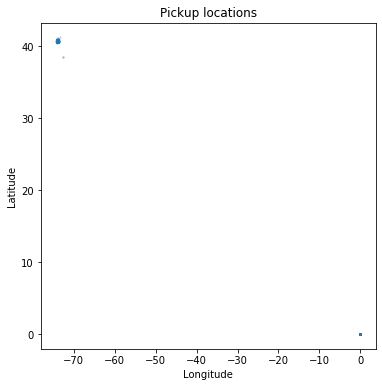

In [10]:
def pickup_scatter(t):
    plt.scatter(t['pickup_lon'], t['pickup_lat'], s=2, alpha=0.2)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Pickup locations')
    
plt.figure(figsize=(6,6))
pickup_scatter(taxi)

As we can see above, there seems to be an outlier at the origin that doesn't seem right for our purposes of dealing with Manhattan taxi rides. This leads to a bad, very zoomed-out plot of the pickup locations. Let's select only those taxi rides that are located within the boundaries of New York City, which are:

 - Longitude: [-74.03, -73.75]
 - Latitude: [40.6, 40.88]
 
In particular, we select all taxi rides where both the pickup and dropoff locations are located within these boundaries.

(97692, 9)

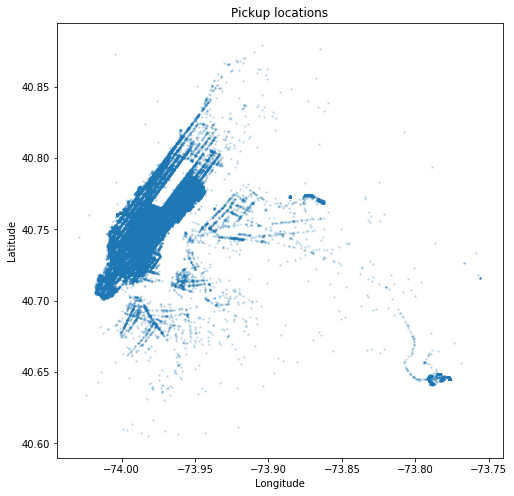

In [42]:
lon_bounds = [-74.03, -73.75]
lat_bounds = [40.6, 40.88]

# Helper function that constructs the string used for the query in selecting datapoints
# where the given field is within the given boundaries
def cons_bound_str(field, bounds):
    return field + " >= " + str(bounds[0]) + " AND " + field + " <= " + str(bounds[1])

pickup_bound_lon = cons_bound_str("pickup_lon", lon_bounds)
pickup_bound_lat = cons_bound_str("pickup_lat", lat_bounds)
dropoff_bound_lon = cons_bound_str("dropoff_lon", lon_bounds)
dropoff_bound_lat = cons_bound_str("dropoff_lat", lat_bounds)

query = "SELECT * FROM taxi WHERE " + pickup_bound_lon + " AND " \
        + pickup_bound_lat + " AND " + dropoff_bound_lon + " AND " + dropoff_bound_lat

taxi = pd.read_sql(query, conn)
plt.figure(figsize=(8,8))
pickup_scatter(taxi)
taxi.shape

We can already see an outline of the streets of Manhattan, along with other points outside the island. Indeed, comparing to a map of New York, we see that there are concentrations of pickups located at the two airports: LaGuardia and JFK. For our purposes, let's look only at taxi rides that start and end within Manhattan island. The csv-file `manhattan.csv` lists the vertices (as longitude, latitude pairs) of the polygon that approximates the boundaries of Manhattan island. We will put the resulting taxi rides into a new dataframe called `manhattan_taxi`.

In [40]:
polygon = pd.read_csv('manhattan.csv')

# Checks whether the given point (x,y) is in Manhattan.
def in_manhattan(x, y):
    num_corners = len(polygon)
    poly_x = polygon['lon']
    poly_y = polygon['lat']
    j = num_corners - 1
    odd_nodes = False
    for i in range(num_corners):
        if (poly_y[i] < y and poly_y[j] >= y) or (poly_y[j] < y and poly_y[i] >= y):
            if poly_x[i]+(y-poly_y[i])/(poly_y[j]-poly_y[i])*(poly_x[j]-poly_x[i]) < x:
                odd_nodes = not odd_nodes
        j = i
    return odd_nodes
    
# Recommended: Then, apply this function to every trip to filter clean_taxi.
pickup_in_manhattan = np.array([in_manhattan(x, y) for x,y in taxi[['pickup_lon', 'pickup_lat']].values])
dropoff_in_manhattan = np.array([in_manhattan(x, y) for x,y in taxi[['dropoff_lon', 'dropoff_lat']].values])
manhattan_taxi = taxi[pickup_in_manhattan & dropoff_in_manhattan]
display(manhattan_taxi.head(10))
manhattan_taxi.shape

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470
5,2016-01-02 12:39:57,2016-01-02 12:53:29,-73.958214,40.760525,-73.983360,40.760406,1,1.70,812
6,2016-01-28 15:39:31,2016-01-29 15:33:00,-73.964432,40.770443,-73.961655,40.774113,1,0.29,86009
8,2016-01-17 19:21:16,2016-01-17 19:28:24,-73.978401,40.764992,-73.981018,40.762100,1,0.95,428
9,2016-01-14 17:54:32,2016-01-14 18:31:14,-73.976173,40.744934,-73.985298,40.714516,1,4.34,2202
10,2016-01-05 12:19:17,2016-01-05 12:30:54,-73.956406,40.768028,-73.978561,40.783222,3,2.07,697
11,2016-01-31 12:07:41,2016-01-31 12:24:53,-74.000114,40.760590,-73.972900,40.748585,1,1.80,1032


(83402, 9)

Finally, let's do some cleaning of the data: in particular, let's only include trips with a positive passenger count, a positive distance, a duration of at least 1 minute and at most 1 hour, and an average speed of at most 100 miles per hour.

In [44]:
manhattan_taxi = manhattan_taxi.query("passengers > 0 and distance > 0 and duration >= 60 and \
                                            duration <= 60*60 and distance / duration <= 100/3600")
manhattan_taxi.shape

(82800, 9)

Now we are done with cleaning our data, so let's begin our exploratory data analysis. To summarize our data pre-processing, of the original 100,000 trips in the original dataset, we first filtered out the trips that either picked up or dropped off outside the boundaries of New York City. This resulted in dataframe consisting of 97,692 trips. We did even further filtering, resulting in 83,402 trips that were located inside Manhattan island. Finally, we cleaned out 602 anamolous trips, resulting in a dataframe of 82,800 rows.

## Exploratory Data Analysis

We wish to develop a general model that could potentially be used for future taxi rides. Of course, unseen future distributions may be different from the distributions in our obtained training data. However, a reasonable assumption is to use typical examples in our training data, as these will best represent future observations, on average.

Let us first make a plot of the total number of taxi rides _by date_. To do this, we will modify the dataframe we have and add a new column that consists of just the date of the pickups of the taxi rides (as opposed to the exact date & time). We see that the datetime columns are actually strings, so we convert to a datetime object in the `date` column.

In [94]:
import datetime

manhattan_taxi['date'] = manhattan_taxi['pickup_datetime'].apply(lambda x: datetime.datetime.strptime(x[:10], '%Y-%m-%d'))
manhattan_taxi.head(5)

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration,date
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981,2016-01-30
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320,2016-01-04
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299,2016-01-07
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470,2016-01-08
5,2016-01-02 12:39:57,2016-01-02 12:53:29,-73.958214,40.760525,-73.983360,40.760406,1,1.70,812,2016-01-02


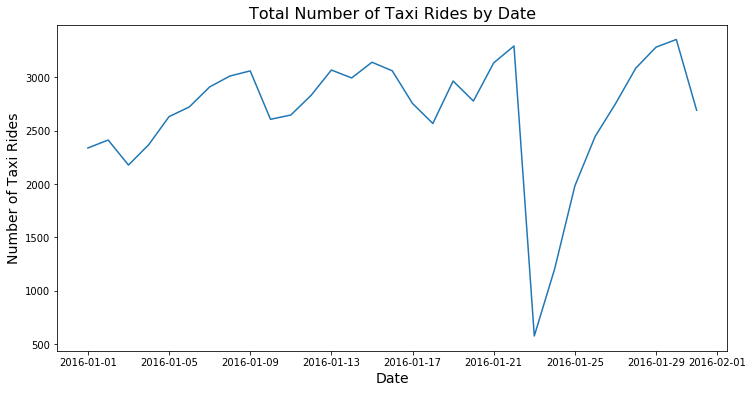

In [93]:
# Plot number of taxi rides by date
plt.figure(figsize=(12, 6))
plt.title("Total Number of Taxi Rides by Date", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Number of Taxi Rides", fontsize=14)
sns.lineplot(data=manhattan_taxi.groupby('date').count()['duration']);

In terms of number of taxi rides, we observe some atypical days, such as New Years Day (January 1) falling on a Friday, MLK Jr. Day (January 18), and a substantial dip in rides on January 23. In fact, a google search reveals that there was an historic blizzard in NYC on the 23rd and 24th of January, 2016. As mentioned above, in order to use this dataset in our regression model, we should account for these phenomena. One simple way to account for this is to remove atypical days from the training data. We choose the first three days of the month, MLK Jr. Day, and the days of and following the blizzard.

In [95]:
import calendar
import re

atypical = [1, 2, 3, 18, 23, 24, 25, 26]
typical_dates = [datetime.date(2016, 1, n) for n in range(1, 32) if n not in atypical]
typical_dates

print('Typical dates:\n')
pat = '  [1-3]|18 | 23| 24|25 |26 '
print(re.sub(pat, '   ', calendar.month(2016, 1)))

manhattan_taxi_final = manhattan_taxi[manhattan_taxi['date'].isin(typical_dates)]

Typical dates:

    January 2016
Mo Tu We Th Fr Sa Su
                    
 4  5  6  7  8  9 10
11 12 13 14 15 16 17
   19 20 21 22      
      27 28 29 30 31

